In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
#!pip install rawpy
import rawpy
from raw_utils import pack_raw
from dataset_navigation import get_image_paths

In [4]:
def load_image(file_path):
    raw = rawpy.imread(file_path).raw_image_visible
    return pack_raw(raw)


In [5]:
paths = get_image_paths()
long_exp_paths = paths["long_exp"]
filtered_exp_paths = paths["filter_long_exp"]
idx = 10
image_diff = load_image(filtered_exp_paths[idx])
image_org = load_image(long_exp_paths[idx])
# Downsample the images
factor = 10
image_diff = cv2.resize(image_diff, (image_diff.shape[1] // factor, image_diff.shape[0] // factor), interpolation=cv2.INTER_LINEAR)
image_org = cv2.resize(image_org, (image_org.shape[1] // factor, image_org.shape[0] // factor), interpolation=cv2.INTER_LINEAR)
image_diff = image_diff / image_diff.max()
image_org = image_org / image_org.max()
print(image_diff.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

(142, 214, 4)
cpu


/home/dofri/epfl/computational_photography/comp-photo-2025/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
import torch
import torch.nn.functional as F

from variance_brightness_analysis import get_brightness_to_std_difference_splines

def fitted_func(x):
    #[TODO This function was only calculated on red channel]
    # This function takes in the pixel brightness and returns the sigma value
    coeffs = [2.94554410e+05, -3.92608548e+02, 1.87221132e-01, -5.09427571e-05,
              6.82300323e-09, -4.20293146e-13, 9.51748215e-18]
    return torch.tensor(np.sqrt(np.abs(np.polyval(coeffs[::-1], x))))

def fitted_func_multi_channel(x, blur_intensity):
    """
    This function takes in the pixel brightness and returns the sigma value for each channel.
    Args:
        x (torch.Tensor): Input tensor with shape (B, C, H, W)
    """
    # Calculate the sigma values for each channel using the provided splines
    splines = get_brightness_to_std_difference_splines()
    sigma = []
    for i in range(x.shape[1]):
        # Get the spline for the current channel
        spline = splines[i]
        # Calculate the sigma values using the spline
        sigma_channel = torch.tensor(spline(x[:, i, :, :].cpu().numpy()), device=x.device)
        sigma.append(sigma_channel)
    # Stack the sigma values to create a tensor with shape (B, C, H, W) 
    sigma = torch.stack(sigma, dim=1)
    return sigma * blur_intensity

def gaussian_kernel(sigma, k_size=3):
    """
    Generate Gaussian kernels for each pixel based on sigma values.

    Args:
        sigma (torch.Tensor): Sigma values with shape (B, C, H, W)
        k_size (int): Kernel size (default: 3)

    Returns:
        torch.Tensor: Gaussian kernels with shape (B, C, H, W, k_size, k_size)
    """
    device = sigma.device
    B, C, H, W = sigma.shape
    radius = k_size // 2

    # Create kernel grid
    y, x = torch.meshgrid(
        torch.arange(-radius, radius + 1, dtype=torch.float32, device=device),
        torch.arange(-radius, radius + 1, dtype=torch.float32, device=device),
        indexing='ij'
    )

    # Reshape for broadcasting
    x = x.view(1, 1, 1, 1, k_size, k_size)  # (1, 1, 1, 1, k, k)
    y = y.view(1, 1, 1, 1, k_size, k_size)
    sigma = sigma.unsqueeze(-1).unsqueeze(-1)  # (B, C, H, W, 1, 1)

    # Compute Gaussian weights
    coeff = 1.0 / (2 * torch.pi * sigma**2)
    exponent = -(x**2 + y**2) / (2 * sigma**2)
    weights = coeff * torch.exp(exponent)

    # Normalize kernels
    weights_sum = weights.sum(dim=(-2, -1), keepdim=True)
    weights = weights / weights_sum
    print(weights.shape)
    return weights

def adaptive_gaussian_conv2d(img, k_size=3, blur_intensity=10):
    """
    Perform spatially adaptive Gaussian convolution.

    Args:
        img (torch.Tensor): Input image with shape (B, C, H, W)
        k_size (int): Kernel size (default: 3)

    Returns:
        torch.Tensor: Convolved output with shape (B, C, H, W)
    """
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
    B, C, H, W = img.shape


    sigma = fitted_func_multi_channel(img, blur_intensity)
    print(sigma.mean())
    print(sigma.shape)

    # Generate Gaussian kernels
    kernels = gaussian_kernel(sigma, k_size).to(img.device)  # (B, C, H, W, k, k)
    print(kernels.shape)
    # print(kernels[0, 0, 0, 0])

    # Unfold input image into patches
    pad = k_size // 2
    unfolded = F.unfold(img, kernel_size=k_size, padding=pad)  # (B, C*k*k, H*W)
    unfolded = unfolded.view(B, C, k_size*k_size, H, W)      # (B, C, k*k, H, W)
    unfolded = unfolded.permute(0, 1, 3, 4, 2)               # (B, C, H, W, k*k)

    # Reshape kernels and multiply with patches
    kernels_flat = kernels.view(B, C, H, W, -1)              # (B, C, H, W, k*k)
    output = (unfolded * kernels_flat).sum(dim=-1)           # (B, C, H, W)

    return output

In [7]:
torch.cuda.empty_cache()

In [8]:

# print(blurred_image.min(), blurred_image.max())
#torch.cuda.empty_cache()

tensor(2.0076, dtype=torch.float64)
torch.Size([1, 4, 142, 214])
torch.Size([1, 4, 142, 214, 29, 29])
torch.Size([1, 4, 142, 214, 29, 29])
(142, 214, 4)


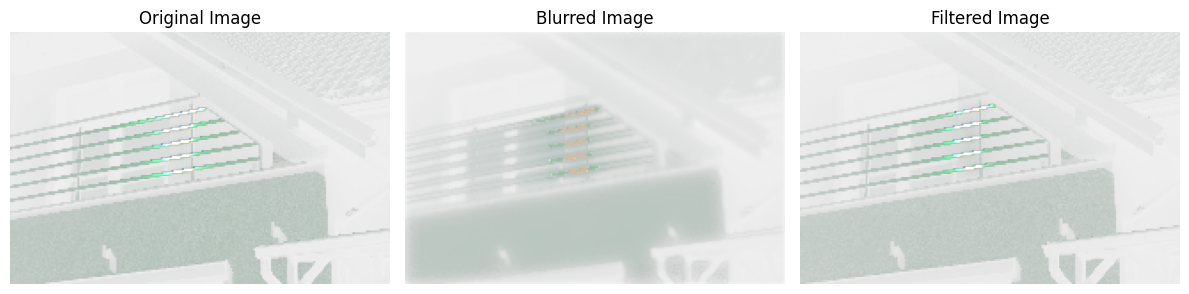

In [9]:
torch.cuda.empty_cache()
x_start = 0
x_end = image_org.shape[1]
y_start = 0
y_end = image_org.shape[0]

blurred_image = adaptive_gaussian_conv2d(image_org[y_start:y_end, x_start:x_end ], k_size=29, blur_intensity=100)[0].permute(1,2,0).cpu().numpy()

plt.figure(figsize=(12, 6))
img_max = image_org[y_start:y_end, x_start:x_end ].max()
plt.subplot(1, 3, 1)
plt.imshow(image_org[y_start:y_end, x_start:x_end ]/img_max)
plt.title("Original Image")
plt.axis("off")


plt.subplot(1, 3, 2)
plt.imshow(np.clip(blurred_image/img_max, 0, 1))
plt.title("Blurred Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image_diff[y_start:y_end, x_start:x_end ]/img_max)
plt.title("Filtered Image")
plt.axis("off")

print(image_diff.shape)
plt.tight_layout()
plt.show()

In [10]:
diff = ((blurred_image - image_org[1200:2100, 1500:2400] / 255.0)[:, :, 0])
plt.imshow(diff, cmap="coolwarm")
plt.colorbar()
diff

ValueError: operands could not be broadcast together with shapes (142,214,4) (0,0,4) 